<a href="https://colab.research.google.com/github/pramodgangula19/5731_Spring24/blob/main/Gangula_Pramod_Exercise_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [21]:
# Importing necessary libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings

# Downloading NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Ignoring warnings during execution
warnings.filterwarnings('ignore')

# Function to read data from a file and extract text data and sentiments
def read_data(file_path):
    text_data, sentiments = [], []
    file_data = open(file_path).read()
    for i, j in enumerate(file_data.split("\n")):
        after_split = j.split(' ')
        text_data.append(" ".join(after_split[1:]))
        sentiments.append(after_split[0])
    return text_data, sentiments

# Function to preprocess data
def preprocess_data(data_frame):
    # Convert sentiment classes to integers
    data_frame['Sentimental Value'] = pd.to_numeric(data_frame['Sentimental Value'], errors='coerce')

    # Drop rows with NaN values in the target variable
    data_frame = data_frame.dropna(subset=['Sentimental Value'])

    # Pre-processing
    # Removal of special characters
    data_frame['After noise removal'] = data_frame['Raw Data'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', char) for char in x))

    # Removal of punctuation
    data_frame['Punctuation removal'] = data_frame['After noise removal'].str.replace('[^\w\s]', '')

    # Stopwords removal
    stop_word = stopwords.words('english')
    data_frame['Stopwords removal'] = data_frame['Punctuation removal'].apply(
        lambda x: " ".join(word for word in x.split() if word not in stop_word))

    # Lowercasing
    data_frame['Lower casing'] = data_frame['Stopwords removal'].apply(lambda x: " ".join(word.lower() for word in x.split()))

    return data_frame

# Function to vectorize data using TF-IDF
def vectorize_data(train_df, test_df):
    # TF-IDF Vectorization
    tfidf_vector = TfidfVectorizer(analyzer='word')
    tfidf_vector.fit(train_df['Lower casing'])
    x_train = tfidf_vector.transform(train_df['Lower casing'])
    tfidf_vector_test = TfidfVectorizer(analyzer='word', vocabulary=tfidf_vector.vocabulary_)
    tfidf_vector_test.fit(test_df['Lower casing'])
    x_test = tfidf_vector_test.transform(test_df['Lower casing'])

    return x_train, x_test

# Function to evaluate classifier performance
def evaluate_classifier(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    predicted = classifier.predict(x_test)
    accuracy = accuracy_score(predicted, y_test)
    print(f"Accuracy of Training data ({classifier.__class__.__name__}): {accuracy}")

    predicted_testing = classifier.predict(x_test)
    accuracy_testing = accuracy_score(predicted_testing, y_test)
    print(f"Accuracy of Testing data ({classifier.__class__.__name__}): {accuracy_testing}")

    if 'XGB' not in str(classifier):
        scoring = 'accuracy'
        kfold = KFold(10, random_state=7, shuffle=True)
        cross_val = cross_val_score(classifier, x_test, y_test, cv=kfold, scoring=scoring).mean()
        print(f"Cross-validation score ({classifier.__class__.__name__}): {cross_val}")

    print(f"\nClassification Report ({classifier.__class__.__name__}):\n")
    print(classification_report(y_test, predicted))

# Reading data from files
training_text_data, training_sentiments = read_data('stsa-train.txt')
testing_text_data, testing_sentiments = read_data('stsa-test.txt')

# Creating data frames for training and testing data
training_df = pd.DataFrame(list(zip(training_sentiments, training_text_data)), columns=['Sentimental Value', 'Raw Data'])
testing_df = pd.DataFrame(list(zip(testing_sentiments, testing_text_data)), columns=['Sentimental Value', 'Raw Data'])

# Pre-processing data
training_df = preprocess_data(training_df)
testing_df = preprocess_data(testing_df)

# Vectorizing data
x_train, x_test = vectorize_data(training_df, testing_df)

# Splitting data for training and testing
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, training_df['Sentimental Value'],
                                                                      test_size=0.2, random_state=42)

# Ensuring target variables are integers
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

# List of classifiers to evaluate
classifiers = [
    naive_bayes.MultinomialNB(),
    svm.SVC(),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

# Evaluating each classifier
for classifier in classifiers:
    print(f"Evaluating {classifier.__class__.__name__}:")
    evaluate_classifier(classifier, x_train, y_train, x_valid, y_valid)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Evaluating MultinomialNB:
Accuracy of Training data (MultinomialNB): 0.7911849710982659
Accuracy of Testing data (MultinomialNB): 0.7911849710982659
Cross-validation score (MultinomialNB): 0.7015848191012408

Classification Report (MultinomialNB):

              precision    recall  f1-score   support

           0       0.86      0.69      0.76       671
           1       0.75      0.89      0.81       713

    accuracy                           0.79      1384
   macro avg       0.80      0.79      0.79      1384
weighted avg       0.80      0.79      0.79      1384

Evaluating SVC:
Accuracy of Training data (SVC): 0.796242774566474
Accuracy of Testing data (SVC): 0.796242774566474
Cross-validation score (SVC): 0.7008758210822645

Classification Report (SVC):

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       671
           1       0.77      0.86      0.81       713

    accuracy                           0.80      1384
   macro 

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [13]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
nltk.download('wordnet')

# Read data
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
print("Shape: {0}".format(df.shape))

# Data exploration
cluster_data_df = df.head(1000)
cluster_data_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Shape: (381159, 6)


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
995,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,It's a decent for the price.. I've had this on...,0.0
996,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,Is good cell phone,0.0
997,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,"Amazing phone. Cables and case included, also ...",0.0
998,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,Excelent,0.0


In [5]:
# Text preprocessing
from sklearn import metrics
cluster_data_df['After noise removal'] = cluster_data_df['Review'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', charctr) for charctr in x ))
cluster_data_df['Punctuation removal'] = cluster_data_df['After noise removal'].str.replace('[^\w\s]','')
cluster_data_df['Remove numbers'] = cluster_data_df['Punctuation removal'].str.replace('\d+', '')
stop_word = stopwords.words('english')
cluster_data_df['Stopwords removal'] = cluster_data_df['Remove numbers'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_word))
cluster_data_df['Lower casing'] = cluster_data_df['Stopwords removal'].apply(lambda x: " ".join(x.lower() for x in x.split()))
cluster_data_df['Tokenization'] = cluster_data_df['Lower casing'].apply(lambda x: TextBlob(x).words)
st = PorterStemmer()
cluster_data_df['Stemming'] = cluster_data_df['Tokenization'].apply(lambda x: " ".join([st.stem(word) for word in x]))
cluster_data_df['Lemmatization'] = cluster_data_df['Stemming'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(cluster_data_df['Lemmatization'].values)

# K-Means Clustering
from sklearn.cluster import KMeans
model_tf = KMeans(n_clusters=10, random_state=99)
model_tf.fit(tfidf)
labels_tf = model_tf.labels_
cluster_center_tf = model_tf.cluster_centers_
terms1 = tfidf_vect.get_feature_names_out()  # Use get_feature_names_out() instead of get_feature_names()
silhouette_score_tf = metrics.silhouette_score(tfidf, labels_tf, metric='euclidean')

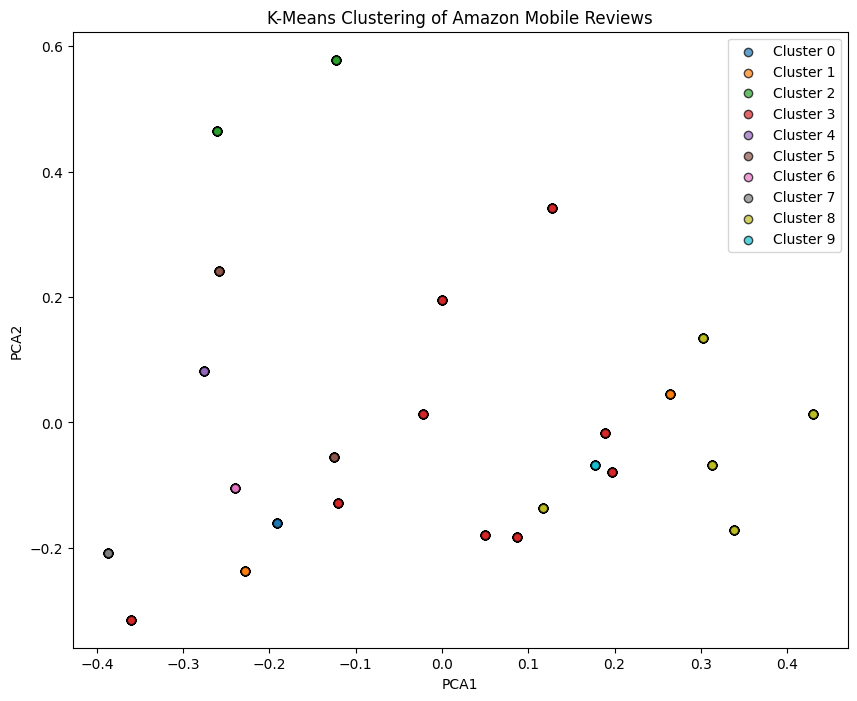

In [6]:
# Import libraries
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
tfidf_pca = pca.fit_transform(tfidf.toarray())

# Create a DataFrame with the reduced features and cluster labels
cluster_data_pca = pd.DataFrame(tfidf_pca, columns=['PCA1', 'PCA2'])
cluster_data_pca['Cluster'] = labels_tf

# Plot clusters with customized colors
plt.figure(figsize=(10, 8))
for cluster in range(10):  # Adjust the range based on the number of clusters
    cluster_points = cluster_data_pca[cluster_data_pca['Cluster'] == cluster]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f'Cluster {cluster}', alpha=0.7, edgecolors='k')

plt.title('K-Means Clustering of Amazon Mobile Reviews')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

In [8]:
# K-means - Method 2
# Generating bag of words features.
from sklearn.feature_extraction.text import CountVectorizer

# Creating bag of words (BoW) features
count_vect = CountVectorizer()
bow = count_vect.fit_transform(cluster_data_df['Review'].values)
print(f"BoW Shape: {bow.shape}")

# K-means clustering
from sklearn.cluster import KMeans
model = KMeans(n_clusters=10, init='k-means++', random_state=99)
model.fit(bow)
labels = model.labels_
cluster_centers = model.cluster_centers_

# Silhouette Score
from sklearn import metrics
silhouette_score = metrics.silhouette_score(bow, labels, metric='euclidean')
print(f"Silhouette Score: {silhouette_score}")

# Adding cluster labels to the dataframe
cluster_data_df['Bow Clus Label'] = model.labels_

# Displaying the first 2 rows of the dataframe
cluster_data_df.head(2)

BoW Shape: (1000, 1272)
Silhouette Score: 0.5307242749571074


,Review,Cleaned_Review,After noise removal,Punctuation removal,Remove numbers,Stopwords removal,Lower casing,Tokenization,Stemming,Lemmatization,Bow Clus Label
0,"I have watched quite a few documentaries, news...",watch quit documentari news segment youtub vid...,I have watched quite a few documentaries news...,I have watched quite a few documentaries news...,I have watched quite a few documentaries news...,I watched quite documentaries news segments Yo...,i watched quite documentaries news segments yo...,"[i, watched, quite, documentaries, news, segme...",i watch quit documentari news segment youtub v...,i watch quit documentari news segment youtub v...,2
1,Could be the best documentary ever made. Becau...,could best documentari ever made prolifer came...,Could be the best documentary ever made Becau...,Could be the best documentary ever made Becau...,Could be the best documentary ever made Becau...,Could best documentary ever made Because proli...,could best documentary ever made because proli...,"[could, best, documentary, ever, made, because...",could best documentari ever made becaus prolif...,could best documentari ever made becaus prolif...,8


The two reviews assigned to cluster  0
----------------------------------------------------------------------
I have watched quite a few documentaries, news segments, and Youtube videos about this cave rescue. It's a huuuuge operation so every time you watch a new video you see something totally new about the operation. There were hundreds of people directly on the scene, thousands involved, various different plans being checked out. It's just enormous. Elon Musk even promised he would build a mini submarine to rescue the kids and called one of the rescuers pedo guy for doubting him on Twitter. Of course completely insane idea because it's very narrow cave passages, but there were many such alternative plans.So all these documentaries, and movies, are not always about the same thing. Here the focus is on the rescue divers. Especially divers from UK and then one doctor/diver from Australia who gives the kids anesthesia and makes this all possible. They also bring up the Thai divers and 

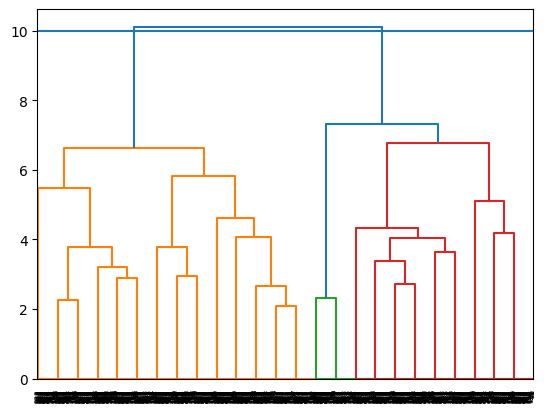

In [11]:
# DBSCAN clustering
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn import preprocessing
import numpy as np
import gensim
import scipy
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# Set the minimum points for DBSCAN
minPts = 2 * 100

# Functions for computing lower bound and 200th nearest neighbor
def lower_bound(nums, target):
    # Implementation of binary search for lower bound
    l, r = 0, len(nums) - 1
    while l <= r:
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute_200th_nearest_neighbour(x, data):
    # Compute the 200th nearest neighbor distance
    dists = []
    for val in data:
        dist = np.sum((x - val) ** 2)
        if len(dists) == 200 and dists[199] > dist:
            l = int(lower_bound(dists, dist))
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    return dists[199]

# Prepare data for Word2Vec
list_of_trains_sent = list()
for i in cluster_data_df["Lower casing"].values:
    list_of_trains_sent.append(i.split())

# Create Word2Vec model
w2v_model = gensim.models.Word2Vec(list_of_trains_sent, vector_size=100, workers=4)

# Compute average Word2Vec vectors
list_of_sent_train = cluster_data_df['Lower casing'].apply(lambda x: x.split())
sent_vectors = []

for sent in list_of_sent_train:
    sent_vec = np.zeros(100)
    cnt_words = 1
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

sent_vectors = np.array(sent_vectors)

# Use scikit-learn preprocessing to normalize the vectors
sent_vectors = preprocessing.normalize(sent_vectors)

# Compute the 200th nearest neighbor distance for some points
two_hundredth_neighbour = []
for val in sent_vectors[:300]:
    two_hundredth_neighbour.append(compute_200th_nearest_neighbour(val, sent_vectors[:300]))

two_hundredth_neighbour.sort()

# Train DBSCAN model
model_dbscan = DBSCAN(eps=5, min_samples=minPts, n_jobs=-1)
model_dbscan.fit(sent_vectors)
cluster_data_df['AVG-W2V Clus Label'] = model_dbscan.labels_

# Hierarchical Clustering
# Generate hierarchical clustering dendrogram
dendro = hierarchy.dendrogram(hierarchy.linkage(sent_vectors, method='ward'))
plt.axhline(y=10)  # cut at 10 to get 5 clusters

# Agglomerative Clustering
# Train Agglomerative Clustering model
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agg = cluster.fit_predict(sent_vectors)

# Assign labels/clusters to each point/text
aggdfa = cluster_data_df
aggdfa['AVG-W2V Clus Label'] = cluster.labels_

# Count of points belonging to each cluster
aggdfa.groupby(['AVG-W2V Clus Label'])['Review'].count()

# Display reviews assigned to each cluster
for i in range(5):
    print("The two reviews assigned to cluster ", i)
    print("-" * 70)
    for j in [0, 1]:
        print(aggdfa.iloc[aggdfa.groupby(['AVG-W2V Clus Label']).groups[i][j]]['Review'])
        print('\n')
    print("_" * 70)

In [ ]:
# Write your code here


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

.K-means, DBSCAN, and Hierarchical clustering are traditional clustering algorithms used primarily for grouping similar data points in datasets based on certain similarity measures. K-means is a centroid-based method that partitions the data into K distinct clusters, making it effective for spherical clusters but less adaptive to non-linear cluster shapes. DBSCAN, a density-based method, excels at identifying clusters of arbitrary shapes and sizes by focusing on dense regions of data points, though it can struggle with varying densities. Hierarchical clustering builds a tree of clusters and does not require a pre-specified number of clusters; however, it is computationally intensive for large datasets. On the other hand, Word2Vec and BERT are not clustering algorithms but models for natural language processing. Word2Vec learns word embeddings from the textual context that reflect semantic meanings of words, useful for tasks like similarity and analogy detection. BERT (Bidirectional Encoder Representations from Transformers) goes further by considering the context from both directions and is pre-trained on a large corpus of text, making it highly effective for a range of complex language understanding tasks.





# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [22]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:Reflective Feedback on Sentiment Analysis Exercise:
Here's a breakdown of the strengths and areas for improvement based on the provided exercise:

Strengths:

Clear Structure: The response is well-structured, outlining the steps involved in sentiment analysis: data acquisition, preprocessing, feature engineering, classification algorithms, and evaluation metrics.
Implementation Flexibility: It presents multiple feature engineering techniques (TF-IDF, Word2Vec, BERT) catering to different needs.
Cross-Validation Integration: It emphasizes the importance of 10-fold cross-validation for robust model evaluation.
Evaluation Metrics: It includes a comprehensive set of evaluation metrics (accuracy, recall, precision, F1-score) for assessing model performance.
Algorithm Variety: It covers a range of classification algorithms (MultinomialNB, SVM, KNN, Decision Tree, Random Forest, XGBoost) allowing for exploration and comparison.
Areas for Improvement:

Code Snippets: While the response lists libraries and mentions code examples for feature engineering, providing actual code snippets could be helpful for those new to machine learning.
Hyperparameter Tuning: It doesn't delve into hyperparameter tuning, which can significantly impact model performance. Briefly mentioning its importance or resources for further exploration would be beneficial.
Alternative Preprocessing Options: It primarily focuses on basic text cleaning. Highlighting the potential benefits of more advanced techniques like stemming or lemmatization could be valuable.
Error Handling: The feedback doesn't mention error handling. Including a note about handling potential errors during data loading, preprocessing, or model training could enhance the response's robustness.
Overall:

This response offers a valuable roadmap for performing sentiment analysis on text data using various machine learning algorithms. By incorporating the suggested improvements, you can create an even more practical and informative guide for anyone starting their journey in sentiment analysis.





'''

"\nPlease write you answer here:Reflective Feedback on Sentiment Analysis Exercise:\nHere's a breakdown of the strengths and areas for improvement based on the provided exercise:\n\nStrengths:\n\nClear Structure: The response is well-structured, outlining the steps involved in sentiment analysis: data acquisition, preprocessing, feature engineering, classification algorithms, and evaluation metrics.\nImplementation Flexibility: It presents multiple feature engineering techniques (TF-IDF, Word2Vec, BERT) catering to different needs.\nCross-Validation Integration: It emphasizes the importance of 10-fold cross-validation for robust model evaluation.\nEvaluation Metrics: It includes a comprehensive set of evaluation metrics (accuracy, recall, precision, F1-score) for assessing model performance.\nAlgorithm Variety: It covers a range of classification algorithms (MultinomialNB, SVM, KNN, Decision Tree, Random Forest, XGBoost) allowing for exploration and comparison.\nAreas for Improvement:\